In [41]:
import numpy as np
import random
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import count
from matplotlib import cm

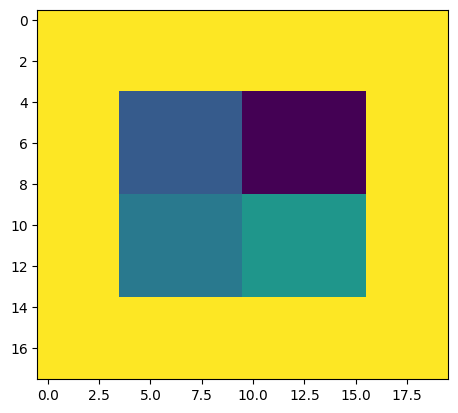

In [42]:
#geometry section
#this benchmark is known as the LWR Pool Reactor, taken from Stepanek (Stepanek, et al., 1982)

sigma_t = [0.6, 0.48, 0.70, 0.65, 0.90]
sigma_s = [0.53, 0.20, 0.66, 0.50, 0.89]
nu_sigma_f = [0.079, 0.0, 0.043, 0.0, 0.0]

azim = 12

X_max = 96
Y_max = 86
alpha = np.array([0,0,0,0])


num_of_mesh_x = 20
num_of_mesh_y = 18
d_star = 2

h_x = X_max/num_of_mesh_x
h_y = Y_max/num_of_mesh_y
x_points = np.arange(0,96+h_x/2,h_x)
x_i = (x_points[0:-1]+x_points[1:])/2
y_points = np.arange(0,86+h_y/2,h_y)
y_j = (y_points[0:-1]+y_points[1:])/2

true_area = h_x*h_y

sigma_t_i_j = np.zeros((num_of_mesh_x,num_of_mesh_y))
sigma_s_i_j = np.zeros((num_of_mesh_x,num_of_mesh_y))
nu_sigmaf_i_j = np.zeros((num_of_mesh_x,num_of_mesh_y))

def material(x,y):
    if(x>=18 and x<=48 and y>=18 and y<=43):
        return 0
    if(x>=48 and x<=78 and y>=18 and y<=43):
        return 1
    if(x>=48 and x<=78 and y>=43 and y<=68):
        return 2
    if(x>=18 and x<=48 and y>=43 and y<=68):
        return 3
    else:
        return 4

for i in range(num_of_mesh_x):
    for j in range(num_of_mesh_y):
        mat = material(x_i[i],y_j[j])
        sigma_s_i_j[i,j] = sigma_s[mat]
        sigma_t_i_j[i,j] = sigma_t[mat]
        nu_sigmaf_i_j[i,j] = nu_sigma_f[mat]


plt.imshow(np.transpose(sigma_t_i_j))

In [43]:
#tabuchi_yamamoto quadrature set
polar =3



sintheta_p = np.array([.166648, .537707, .932954])
theta_p = (np.arcsin(sintheta_p))

w_p = 2*(np.array([0.046233, 0.283619, 0.670148]))


#azimuthal angle the angles in the definition given in 3.79 from azman rafee


B = int(azim/4)
w_b0 = np.pi/2/B
beta_b = np.arange(w_b0/2, np.pi/2, w_b0)
w_b = np.ones(int(B))*w_b0

print(beta_b)

np.cos(beta_b)

[0.26179939 0.78539816 1.30899694]


array([0.96592583, 0.70710678, 0.25881905])

In [44]:
#ray tracing data:

n_x = np.zeros(B)
n_y = np.zeros(B)
delta_x = np.zeros(B)
delta_y = np.zeros(B)
ray_spacing = np.zeros(B)

#calculation of corrected azimuthal angles
for b in range(B):
    n_x[b] = round(X_max/d_star * abs(np.sin(beta_b[b])))
    #print((X_max/d_star * abs(np.sin(beta_b[b]))))
    n_y[b] = round(Y_max/d_star * abs(np.cos(beta_b[b])))
    #print(round(Y_max/d_star * abs(np.cos(beta_b[b]))))
    delta_x[b] = X_max/n_x[b]
    #print(delta_x[b])
    delta_y[b] = Y_max/n_y[b]
    #print(delta_y[b])

    beta_b[b] = np.arctan(delta_y[b]/delta_x[b])
    ray_spacing[b] = delta_x[b]*delta_y[b]/np.sqrt(delta_x[b]**2+delta_y[b]**2)

w_b[0] = 1/2 * (beta_b[0]+beta_b[1])
for b in range(1,B):
    if(b==B-1):
        w_b[b] =np.pi/2 -  1/2*(beta_b[b-1]+beta_b[b])
        
    else:
        w_b[b] = 1/2*(beta_b[b+1]-beta_b[b-1])


x_0b = []

for b in range(B):
    x_0= list(np.arange(delta_x[b]/2, X_max, delta_x[b] ))
    x_0b.append(x_0)



In [45]:
def F_1(tau):
    return 1-np.exp(-tau)

def F_2(tau_m, tau_mki):
    return 2*(tau_m - F_1(tau_m)) - tau_mki * F_1(tau_m)

def G_1(tau):
    return 1+tau/2-(1+1/tau)*F_1(tau)

def G_2(tau):
    return 2/3*tau - (1+2/tau)*G_1(tau)

def H__(tau):
    return tau/2 - G_1(tau)


In [46]:
class mesh_class:
    def __init__(self, x_mid, y_mid):
        self.centroid = np.array([x_mid,y_mid])

        self.Mxx = 0.0
        self.Myy = 0.0
        self.Mxy = 0.0

        self.Cx = 0.0
        self.Cy = 0.0 
        self.Cxy = 0.0
        
        self.inv_moment_mat = np.zeros((3,3))
        
        self.tracks = []

mesh_objects_ij = [[mesh_class(x_i[i], y_j[j])for j in range(num_of_mesh_y)]for i in range(num_of_mesh_x)]

mesh_objects_ij[2][3].centroid

array([12.        , 16.72222222])

In [47]:
class track_class:
    def __init__(self, track_len, mesh, start_point, end_point, beta, b_v_k):
        self.track_len_xy = track_len
        self.mesh = mesh.copy()
        self.start_point = np.array(start_point)
        self.end_point = np.array(end_point)
        self.mid_point = 1/2*(start_point+end_point)
        self.beta = beta
        self.b_v_k = b_v_k.copy()
        self.track_len_p = track_len/sintheta_p

In [48]:
#the list of object used in code for this class is ray_objects_k 
class single_ray_class:
    def __init__(self, mesh_reached, tracklengths_in_ray,boun_start,points_touched, beta_angles):
        self.mesh_reached = mesh_reached.copy()
        self.tracklengths_in_ray =tracklengths_in_ray.copy()
        self.num_of_tracks_in_ray = len(tracklengths_in_ray)
        self.real_track_lengths = np.empty((polar,self.num_of_tracks_in_ray))
        self.E_factor = np.empty(((polar,self.num_of_tracks_in_ray)))
        self.F_factors = np.empty((2,polar,self.num_of_tracks_in_ray))
        self.G_factors = np.empty((2,polar,self.num_of_tracks_in_ray))
        self.H_factor = np.empty((polar,self.num_of_tracks_in_ray))
        self.boun_start = boun_start.copy()
        self.track_lengths_xy= tracklengths_in_ray.copy()
        self.start_points = np.array([points_touched[0][0:-1], points_touched[1][0:-1]])
        self.end_points = np.array([points_touched[0][1:], points_touched[1][1:]])
        self.mid_points = (self.start_points+self.end_points)/2
        self.beta_angles = beta_angles.copy()
        self.points_touched = points_touched.copy()
        

In [49]:
#the list of object used in code for this class is azimuthal_beta_objects_b
class azimuthal_beta_class:
    def __init__(self,ray_objects_k,sum_of_tk_orien_mesh,b):
        
        
        for k in range(len(ray_objects_k)):
            #the commented section below was intended to address area correction of tracklengths but did not work
            #for v in range ((ray_objects_k[k].num_of_tracks_in_ray)):
            
            #    ray_objects_k[k].tracklengths_in_ray[v] = ray_objects_k[k].tracklengths_in_ray[v]*true_area/(ray_spacing[b]*sum_of_tk_orien_mesh[ray_objects_k[k].mesh_reached[v][2],ray_objects_k[k].mesh_reached[v][0],ray_objects_k[k].mesh_reached[v][1]])
            for p in range(polar):
                ray_objects_k[k].real_track_lengths[p] = np.array(ray_objects_k[k].tracklengths_in_ray)/sintheta_p[p]
                for v in range(ray_objects_k[k].num_of_tracks_in_ray) :   
                    ray_objects_k[k].E_factor[p,v] = 1-np.exp(-ray_objects_k[k].real_track_lengths[p,v] * sigma_t_i_j[ray_objects_k[k].mesh_reached[v][0],ray_objects_k[k].mesh_reached[v][1]])
                    ray_objects_k[k].F_factors[0,p,v] = F_1(ray_objects_k[k].real_track_lengths[p,v] * sigma_t_i_j[ray_objects_k[k].mesh_reached[v][0],ray_objects_k[k].mesh_reached[v][1]])
                    ray_objects_k[k].F_factors[1,p,v] = F_2(ray_objects_k[k].real_track_lengths[p,v] * sigma_t_i_j[ray_objects_k[k].mesh_reached[v][0],ray_objects_k[k].mesh_reached[v][1]],ray_objects_k[k].real_track_lengths[p,v] * sigma_t_i_j[ray_objects_k[k].mesh_reached[v][0],ray_objects_k[k].mesh_reached[v][1]])
                    ray_objects_k[k].G_factors[0,p,v] = G_1(ray_objects_k[k].real_track_lengths[p,v] * sigma_t_i_j[ray_objects_k[k].mesh_reached[v][0],ray_objects_k[k].mesh_reached[v][1]])
                    ray_objects_k[k].G_factors[1,p,v] = G_2(ray_objects_k[k].real_track_lengths[p,v] * sigma_t_i_j[ray_objects_k[k].mesh_reached[v][0],ray_objects_k[k].mesh_reached[v][1]])
                    ray_objects_k[k].H_factor[p,v] = H__(ray_objects_k[k].real_track_lengths[p,v] * sigma_t_i_j[ray_objects_k[k].mesh_reached[v][0],ray_objects_k[k].mesh_reached[v][1]])

            #print(b,k,np.amin(ray_objects_k[k].E_factor))
        


        self.ray_objects_k=ray_objects_k.copy()
        self.sum_l_o_i_j = sum_of_tk_orien_mesh.copy() 
        
        
        

In [50]:
def get_track_b_p_v_k(b,p,v,k):
    
    return azimuthal_beta_objects_b[b].ray_objects_k[k].real_track_lengths[p][v]

def get_xy_track_b_v_k(b,v,k):
    
    return azimuthal_beta_objects_b[b].ray_objects_k[k].track_lengths_xy[v]

def get_mesh_b_v_k(b,v,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].mesh_reached[v]

def get_E_factor_b_p_v_k(b,p,v,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].E_factor[p,v]

def get_F_factors_b_p_v_k(b,p,v,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].F_factors[:,p,v]

def get_G_factors_b_p_v_k(b,p,v,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].G_factors[:,p,v]

def get_H_factors_b_p_v_k(b,p,v,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].H_factor[p,v]

def get_boun_start_b_v_k(b,v,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].boun_start[v]

def get_num_of_tracks_b_k(b,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].num_of_tracks_in_ray

def get_sum_l_b_o_i_j(b,o,i,j):
    return azimuthal_beta_objects_b[b].sum_l_o_i_j[o,i,j]

def get_start_point_b_v_k(b,v,k):
    return [azimuthal_beta_objects_b[b].ray_objects_k[k].start_points[0,v],azimuthal_beta_objects_b[b].ray_objects_k[k].start_points[1,v]]

def get_end_point_b_v_k(b,v,k):
    return [azimuthal_beta_objects_b[b].ray_objects_k[k].end_points[0,v],azimuthal_beta_objects_b[b].ray_objects_k[k].end_points[1,v]]

def get_mid_point_b_v_k(b,v,k):
    return [azimuthal_beta_objects_b[b].ray_objects_k[k].mid_points[0,v],azimuthal_beta_objects_b[b].ray_objects_k[k].mid_points[1,v]]

def get_beta_angle_b_v_k(b,v,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].beta_angles[v]
  

In [51]:
#ray tracing


azimuthal_beta_objects_b = []
total_tracks = 0

num_of_rays_in_beta_b = []
for b in range(B):
    print(b)
    sum_of_tk_orien_mesh = np.zeros((2,num_of_mesh_x, num_of_mesh_y))

    ray_objects_k = []
    beta = beta_b[b]
    m= np.tan(beta)
    x_0b_size = len(x_0b[b])
    ray = 0
    
    while(ray<x_0b_size):
        mesh_shift_x = int(1)
        mesh_shift_y = int(1)

        mesh_reached=[]
        interceptsx = []
        interceptsy = []
        tracklengths_in_ray = []
        
        #find the mesh to start the ray from
        mesh_boun_x_behind=0
        mesh_boun_y_behind=0
        for mesh_boun_x_behind in range(len(x_points)):
            if(x_0b[b][ray]<x_points[mesh_boun_x_behind]):
                break
        mesh_boun_x_behind=mesh_boun_x_behind-1
       
        
        # entering mesh mesh_boun_x_behind,mesh_boun_y_behind starting at (x_0,0)
        mesh_now = [mesh_boun_x_behind,mesh_boun_y_behind, 0] # mesh reached with a orientation 0 or 1
        point_now = np.array([x_0b[b][ray],0])

        point_old = point_now.copy()
        mesh_old = mesh_now.copy()

        points_touched=[]
        interceptsx.append(point_now[0])
        interceptsy.append(point_now[1])
        track_len_in_mesh = np.zeros(0)
        boun_start = [0] 
        orien = 0
        
        #print('angle',b ,'ray',ray,"enterd", [point_now[0],point_now[1]], mesh_now,'ray:', ray,'from boun', boun_start)
        
        track_number_in_ray = 0
        beta_angles = []
        while(1):
            v = track_number_in_ray
            total_tracks = total_tracks+1
        
            orien = 0 if m>0 else 1
            mesh_now[2] = orien
            ##
            ##
            beta_angles.append(beta) #this will be used in evaluation of the constants in linear source equations as well in the new transport sweep
            ##
            ##

            vertical_cut = m*(x_points[mesh_boun_x_behind+mesh_shift_x]-point_now[0])
            
            point_old = point_now.copy()
            mesh_old = mesh_now.copy()
            if(mesh_now[0:-1]==[0,0]):
                print('angle',b ,'ray',ray,"enterd", mesh_now,'through', [point_now[0],point_now[1]],'track_number:', track_number_in_ray,'from boun', boun_start[-1])                
            if(abs(abs(vertical_cut)-abs(y_points[mesh_boun_y_behind+mesh_shift_y]-point_now[1]))<10**-13):

                #    print('igonred:', b,ray,v)
                #    print('igonred','angle',b ,'ray',ray,"enterd", [point_now[0],point_now[1]],mesh_now,'ray:', ray,'track_number:', track_number_in_ray,'from boun', boun_start[-1])                
                horizontal_cut = x_points[mesh_boun_x_behind+mesh_shift_x] - point_now[0]
                
                track_len_in_mesh = np.sqrt(horizontal_cut**2+vertical_cut**2)
                tracklengths_in_ray.append(track_len_in_mesh)
                
                
                sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]] = sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]]+track_len_in_mesh

                mesh_reached.append(mesh_now.copy())

                
                point_now[0] = x_points[mesh_boun_x_behind+mesh_shift_x]
                point_now[1] = point_now[1] + abs(vertical_cut)*mesh_shift_y

                mesh_boun_x_behind=mesh_boun_x_behind+mesh_shift_x
                mesh_boun_y_behind = mesh_boun_y_behind+mesh_shift_y

                mesh_now[0] = mesh_now[0]+mesh_shift_x
                mesh_now[1] = mesh_now[1]+mesh_shift_y 
                                    
            elif(abs(vertical_cut)<abs(y_points[mesh_boun_y_behind+mesh_shift_y]-point_now[1])):

                horizontal_cut = x_points[mesh_boun_x_behind+mesh_shift_x] - point_now[0]
                                
                track_len_in_mesh = np.sqrt(horizontal_cut**2+vertical_cut**2)
                tracklengths_in_ray.append(track_len_in_mesh)                
                
                sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]] = sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]]+track_len_in_mesh
                mesh_reached.append(mesh_now.copy())

                #    print('angle',b ,'ray',ray,"exit",[point_now[0],point_now[1]],'from',  mesh_reached[-1], 'ray:', ray,'track_number:', track_number_in_ray,'len', track_len_in_mesh,'sum', sum_of_tk_orien_mesh[mesh_now[0],mesh_now[1]])
                point_now[0] = x_points[mesh_boun_x_behind+mesh_shift_x]
                point_now[1] = point_now[1]+abs(vertical_cut)*mesh_shift_y

                mesh_boun_x_behind=mesh_boun_x_behind+mesh_shift_x
                mesh_now[0] = mesh_now[0]+mesh_shift_x 
                                    
            else:
                
                #    print('angle',b ,'ray',ray,"enterd", [point_now[0],point_now[1]],mesh_now, 'ray:', ray,'track_number:', track_number_in_ray,'from boun',boun_start[-1])

                
                
                vertical_cut = y_points[mesh_boun_y_behind+mesh_shift_y] - point_now[1]                
                horizontal_cut = vertical_cut/m
                
                track_len_in_mesh = np.sqrt(horizontal_cut**2+vertical_cut**2)
                tracklengths_in_ray.append(track_len_in_mesh)

                sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]] = sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]]+track_len_in_mesh
                mesh_reached.append(mesh_now.copy())
            
                #    print('angle',b ,'ray',ray,"exit", [point_now[0],point_now[1]],'from', mesh_reached[-1], 'ray:', ray,'track_number:', track_number_in_ray,'len', track_len_in_mesh, track_number_in_ray,'sum', sum_of_tk_orien_mesh[mesh_now[0],mesh_now[1]])
                
                point_now[0] = point_now[0]+abs(horizontal_cut)*mesh_shift_x
                point_now[1] = y_points[mesh_boun_y_behind+mesh_shift_y]
                mesh_boun_y_behind = mesh_boun_y_behind+mesh_shift_y
                mesh_now[1] = mesh_now[1]+mesh_shift_y

            track_object = track_class(track_len_in_mesh,mesh_old, point_old, point_now, beta, [b,v,ray])
            mesh_objects_ij[mesh_old[0]][mesh_old[1]].tracks.append(track_object)

            

            track_number_in_ray=track_number_in_ray+1
            interceptsx.append(point_now[0])
            interceptsy.append(point_now[1])

            #print('next mesh withount boundary correction:',mesh_now)
            #now it's time to reflect some rays
            boun = -1
            if(point_now[0]==x_points[-1]):
                boun = 1
                #here at right boundary 
                
                mesh_shift_x = -1
                mesh_now[0] = num_of_mesh_x-1
                
                mesh_shift_y= int(np.sign(np.sin(beta))) #so is this
                
                

                beta = np.pi-mesh_shift_y*beta_b[b] #its okay you thought about it already

                m=np.tan(beta)
                

                #print(b,ray,[point_now[0],point_now[1]], mesh_now, boun_start[-1],track_number_in_ray)

            if(point_now[1]>y_points[-1] or abs(point_now[1]-y_points[-1])<10**-13 ):
                boun =2
                #here at upper boundary
                mesh_shift_y = -1
                mesh_now[1] = num_of_mesh_y-1
                mesh_shift_x= int(np.sign(np.cos(beta)))
                

                beta = 3/2*np.pi+mesh_shift_x*(np.pi/2 - beta_b[b])
                m = np.tan(beta)
               

                #print(b,ray,[point_now[0],point_now[1]], mesh_now, boun_start[-1],track_number_in_ray)

            if(point_now[0]==0):
                boun = 3
                #here at left boundary
                mesh_shift_x = 1
                mesh_now[0] = 0
                mesh_shift_y= int(np.sign(np.sin(beta)))
                

                beta = np.pi-mesh_shift_y*(np.pi-beta_b[b])
                m = np.tan(beta)

                #print(b,ray,[point_now[0],point_now[1], mesh_now, boun_start[-1],track_number_in_ray)
                

            if((point_now[1])<10**-13):
                boun = 0
                #here at lower boundary, here the ray might terminate, so this part of if is big, here we also delete unnecessary ray starting point
                mesh_shift_y = 1
                mesh_now[1] = 0
                mesh_shift_x= int(np.sign(np.cos(beta)))
                

                beta = np.pi/2-mesh_shift_x*(np.pi/2 - beta_b[b])
                m = np.tan(beta)
                orien = 0 if m>0 else 1
                #here we also delete unnecessary ray starting point
                ind = ray+1
                #ray delete
                while(ind<x_0b_size ):
                    if(abs(x_0b[b][ind]-point_now[0])<10**-10):
                        #print( [x_0b[b][ind],point_now[0]])
                        x_0b[b].pop(ind)
                        x_0b_size = len(x_0b[b])
                        ind = ind-1
                        #print('deleted','angle', b, 'ray', ind, 'now rays', x_0b_size)
                            
                    ind=ind+1                
                
                       
                
                #print(b,ray,[point_now[0],point_now[1]], mesh_now, boun_start[-1],track_number_in_ray)
                if(abs(point_now[0] - x_0b[b][ray])<10**-10):
                    #print(b,v,ray, [point_now[0], x_0b[b][ray]])
                    points_touched=[interceptsx.copy(), interceptsy.copy()]
                    boun_start.append(boun)
                    
                    break
            #print('angle',b ,'ray',ray,"exit to",mesh_now,'through', [point_now[0],point_now[1]],'to boun', boun ,'track_number:', track_number_in_ray,'len', track_len_in_mesh, track_number_in_ray,'sum', sum_of_tk_orien_mesh[mesh_now[0],mesh_now[1]])
        
            boun_start.append(boun)
                
            
 
        
           
        ray_objects_k.append(single_ray_class(mesh_reached, np.array(tracklengths_in_ray),boun_start,points_touched, beta_angles))
        
        #print(b,ray,len(mesh_reached), len(boun_start))   
        ray = ray+1
    num_of_rays_in_beta_b.append(x_0b_size)
    print(ray_objects_k)
    azimuthal_beta_objects_b.append(azimuthal_beta_class(ray_objects_k,sum_of_tk_orien_mesh,b))
    #print(b,np.min(azimuthal_beta_objects_b[b].ray_objects_k[0].E_factor))




#xx,yy = np.meshgrid(x_points,y_points)
#plt.plot(xx, yy,color='black',linewidth=0.5)
#plt.plot(yy,xx, color ='black', linewidth = 0.5)


0
angle 0 ray 0 enterd [0, 0, 0] through [4.0, 0.0] track_number: 0 from boun 0
angle 0 ray 0 enterd [0, 0, 0] through [4.8, 2.252380952380931] track_number: 350 from boun -1
angle 0 ray 0 enterd [0, 0, 1] through [0.0, 1.0238095238095026] track_number: 351 from boun 3
angle 0 ray 1 enterd [0, 0, 0] through [4.8, 4.299999999999984] track_number: 348 from boun -1
angle 0 ray 1 enterd [0, 0, 1] through [0.0, 3.071428571428555] track_number: 349 from boun 3
angle 0 ray 2 enterd [0, 0, 1] through [1.3333333333332604, 4.777777777777778] track_number: 347 from boun -1
[<__main__.single_ray_class object at 0x0000019A89905190>, <__main__.single_ray_class object at 0x0000019A890B77D0>, <__main__.single_ray_class object at 0x0000019A89529C90>, <__main__.single_ray_class object at 0x0000019A8914FCD0>, <__main__.single_ray_class object at 0x0000019A890E2D50>, <__main__.single_ray_class object at 0x0000019A89449650>]
1
angle 1 ray 0 enterd [0, 0, 0] through [1.411764705882353, 0.0] track_number: 0 

In [52]:
##linear source data after ray tracing

for i in range(num_of_mesh_x):
    for j in range(num_of_mesh_y):
        mesh_object = mesh_objects_ij[i][j]
        Mxx_sum_b = 0
        Myy_sum_b = 0
        Mxy_sum_b = 0
        Cx_sum_b = [0, 0]
        Cy_sum_b = [0, 0]
        Cxy_sum_b = [0, 0]
        for t in range(len(mesh_object.tracks)):
            track = mesh_object.tracks[t]
            s_a_k_i = track.track_len_xy
            [b,v,k] = track.b_v_k
            beta = track.beta
            [X_in, Y_in] = track.start_point
            [X_c, Y_c] = mesh_object.centroid
            [x_c, y_c] = list(track.mid_point - mesh_object.centroid)
            for p in range(polar):
                t_m_k_i = track.track_len_p[p]
                tau_m_k_i = t_m_k_i*sigma_t_i_j[i,j]
                a_x_m = (sintheta_p[p]*np.cos(beta))
                a_y_m = (sintheta_p[p]*np.sin(beta))
                Mxx_sum_b = Mxx_sum_b+ w_b[b]*w_p[p]*sintheta_p[p]/(true_area/ray_spacing[b])* (1/3*(a_x_m)**2 * t_m_k_i**3 + a_x_m*(X_in-X_c)*t_m_k_i**2 + t_m_k_i*(X_in-X_c)**2 )
                Myy_sum_b = Myy_sum_b+ w_b[b]*w_p[p]*sintheta_p[p]/(true_area/ray_spacing[b])* (1/3*(a_y_m)**2 * t_m_k_i**3 + a_y_m*(Y_in-Y_c)*t_m_k_i**2 + t_m_k_i*(Y_in-Y_c)**2 )
                Mxy_sum_b = Mxy_sum_b+ w_b[b]*w_p[p]*sintheta_p[p]/(true_area/ray_spacing[b])* (1/3*(a_y_m)*(a_x_m) * t_m_k_i**3 + 1/2*(a_x_m*(Y_in-Y_c)+a_y_m*(X_in-X_c))*t_m_k_i**2 + t_m_k_i*(Y_in-Y_c)*(X_in-X_c))

                Cx_sum_b[0] = Cx_sum_b[0] + ray_spacing[b]*w_b[b]*w_p[p]*sintheta_p[p]*(np.cos(beta)*s_a_k_i)**2 * G_2(tau_m_k_i)
                Cy_sum_b[0] = Cy_sum_b[0] + ray_spacing[b]*w_b[b]*w_p[p]*sintheta_p[p]*(np.sin(beta)*s_a_k_i)**2 * G_2(tau_m_k_i)
                Cxy_sum_b[0] = Cxy_sum_b[0] + ray_spacing[b]*w_b[b]*w_p[p]*sintheta_p[p]*(np.cos(beta)*np.sin(beta))*(s_a_k_i)**2 * G_2(tau_m_k_i)
            
            [X_in, Y_in] = track.end_point
            beta=beta+np.pi
            for p in range(polar):    
                a_x_m = (sintheta_p[p]*np.cos(beta))
                a_y_m = (sintheta_p[p]*np.sin(beta))
                Mxx_sum_b = Mxx_sum_b+ w_b[b]*w_p[p]*sintheta_p[p]/(true_area/ray_spacing[b])* (1/3*(a_x_m)**2 * t_m_k_i**3 + a_x_m*(X_in-X_c)*t_m_k_i**2 + t_m_k_i*(X_in-X_c)**2 )
                Myy_sum_b = Myy_sum_b+ w_b[b]*w_p[p]*sintheta_p[p]/(true_area/ray_spacing[b])* (1/3*(a_y_m)**2 * t_m_k_i**3 + a_y_m*(Y_in-Y_c)*t_m_k_i**2 + t_m_k_i*(Y_in-Y_c)**2 )
                Mxy_sum_b = Mxy_sum_b+ w_b[b]*w_p[p]*sintheta_p[p]/(true_area/ray_spacing[b])* (1/3*(a_y_m)*(a_x_m) * t_m_k_i**3 + 1/2*(a_x_m*(Y_in-Y_c)+a_y_m*(X_in-X_c))*t_m_k_i**2 + t_m_k_i*(Y_in-Y_c)*(X_in-X_c))        
            
            Cx_sum_b[1] = Cx_sum_b[1] + ray_spacing[b]*w_b[b]*(x_c)**2 * s_a_k_i
            Cy_sum_b[1] = Cy_sum_b[1] + ray_spacing[b]*w_b[b]*(y_c)**2 * s_a_k_i
            Cxy_sum_b[1] = Cxy_sum_b[1] +ray_spacing[b]*w_b[b]*(x_c*y_c) * s_a_k_i

        mesh_objects_ij[i][j].Cx = 1/(sigma_t_i_j[i,j]*true_area) * Cx_sum_b[0] + 2/true_area*Cx_sum_b[1]
        mesh_objects_ij[i][j].Cy = 1/(sigma_t_i_j[i,j]*true_area) * Cy_sum_b[0] + 2/true_area*Cy_sum_b[1]
        mesh_objects_ij[i][j].Cxy = 1/(sigma_t_i_j[i,j]*true_area) * Cxy_sum_b[0] + 2/true_area*Cxy_sum_b[1]

        Mxx = Mxx_sum_b
        Myy = Myy_sum_b
        Mxy = Mxy_sum_b
        
        mesh_objects_ij[i][j].Mxx = Mxx
        mesh_objects_ij[i][j].Myy = Myy
        mesh_objects_ij[i][j].Mxy = Mxy
        mesh_objects_ij[i][j].inv_moment_mat=np.linalg.inv(np.array([[1,0,0],[0,Mxx,Mxy],[0,Mxy,Myy]]))

In [53]:
def two_D_sweep_linear(Q_moments_i_j,psi):
    psi_boun = []
    psi_in_b_p_k = psi.copy()
    q_moments_i_j = np.zeros((3,num_of_mesh_x,num_of_mesh_y))
    flux_moments_i_j = np.zeros((3,num_of_mesh_x, num_of_mesh_y))
    for i in range(num_of_mesh_x):
        for j in range(num_of_mesh_y):
            q_moments_i_j[:,i,j] = np.matmul(mesh_objects_ij[i][j].inv_moment_mat,Q_moments_i_j[:,i,j])
            flux_moments_i_j[0,i,j] = 4*np.pi*q_moments_i_j[0,i,j]/sigma_t_i_j[i,j]
            flux_moments_i_j[1,i,j] = q_moments_i_j[1,i,j]/sigma_t_i_j[i,j]*mesh_objects_ij[i][j].Cx + q_moments_i_j[2,i,j]/sigma_t_i_j[i,j]*mesh_objects_ij[i][j].Cxy
            flux_moments_i_j[2,i,j] = q_moments_i_j[2,i,j]/sigma_t_i_j[i,j]*mesh_objects_ij[i][j].Cy + q_moments_i_j[1,i,j]/sigma_t_i_j[i,j]*mesh_objects_ij[i][j].Cxy
     #this q_i will be different for each mesh
    
    
    for b in range(B):
        for k in range(num_of_rays_in_beta_b[b]):
            v=0
            direction = 1 #this means ray is traced forward so v increment by one and backward v decrement 1
            bounce = 1 #while going forard it looks for boundary at next mesh, when going backward looks four boundary at own mesh
            V=get_num_of_tracks_b_k(b,k)
            while(v>=0):
                
                [i, j, o] = get_mesh_b_v_k(b,v,k)
                hit_boun = get_boun_start_b_v_k(b,v+bounce,k)
                
                if(direction==1):
                    beta = get_beta_angle_b_v_k(b,v,k)
                    [x_in, y_in] = get_start_point_b_v_k(b,v,k) - mesh_objects_ij[i][j].centroid
                if(direction == -1):
                    beta = get_beta_angle_b_v_k(b,v,k)+np.pi
                    [x_in, y_in] = get_end_point_b_v_k(b,v,k) - mesh_objects_ij[i][j].centroid
                [x_c, y_c] = get_mid_point_b_v_k(b,v,k) - mesh_objects_ij[i][j].centroid
                for p in range(polar):
                    t_m_k_i = get_track_b_p_v_k(b,p,v,k)
                    s_a_k_i = get_xy_track_b_v_k(b,v,k)
                    
                    [F_1, F_2] = get_F_factors_b_p_v_k(b,p,v,k)
                    [G_1, G_2] = get_G_factors_b_p_v_k(b,p,v,k)
                    H = get_H_factors_b_p_v_k(b,p,v,k)
                    q_cap = 1/(4*np.pi) * (q_moments_i_j[1,i,j]*sintheta_p[p]*np.cos(beta)+q_moments_i_j[2,i,j]*sintheta_p[p]*np.sin(beta))
                    q_bar = 1/(4*np.pi) * ( q_moments_i_j[0,i,j] + q_moments_i_j[1,i,j]*x_c+ q_moments_i_j[2,i,j]*y_c) 
                    del_psi =(psi_in_b_p_k[b][p,k] - q_bar/sigma_t_i_j[i,j])*F_1 - q_cap/(2*(sigma_t_i_j[i,j])**2)*F_2

                    flux_moments_i_j[0,i,j] = flux_moments_i_j[0,i,j]+ 4*np.pi/(sigma_t_i_j[i,j]*true_area) * w_b[b]*ray_spacing[b] * w_p[p]*sintheta_p[p] * del_psi
                    flux_moments_i_j[1,i,j] = flux_moments_i_j[1,i,j]+ 4*np.pi/(sigma_t_i_j[i,j]*true_area) * w_b[b]*ray_spacing[b] * w_p[p]*sintheta_p[p] *(np.cos(beta)*s_a_k_i*psi_in_b_p_k[b][p,k]*H + x_in *del_psi)
                    flux_moments_i_j[2,i,j] = flux_moments_i_j[2,i,j]+ 4*np.pi/(sigma_t_i_j[i,j]*true_area) * w_b[b]*ray_spacing[b] * w_p[p]*sintheta_p[p] *(np.sin(beta)*s_a_k_i*psi_in_b_p_k[b][p,k]*H + y_in *del_psi)
                    
                    psi_in_b_p_k[b][p,k] = psi_in_b_p_k[b][p,k] - del_psi
                #print(np.round(flux_moments_i_j[0].copy(), decimals=4, out=None))
                #print(b,v,k,psi_in_b_p_k[b][:,k])
                
                
                #print('b',b,'v',v,'k',k,[i,j], hit_boun,psi_in_b_p_k[b][:,k])

                if(hit_boun !=-1):
                    if(get_xy_track_b_v_k(b,v,k)>10**-13):
                         
                        psi_boun.append(np.array(psi_in_b_p_k[b][:,k]))               
                    #print('boun',b,v,k,hit_boun,psi_in_b_p_k[b][:,k]) 
                    #print(psi_boun)   
                    psi_in_b_p_k[b][:,k] = alpha[hit_boun]*psi_in_b_p_k[b][:,k]
                    #print('boun',psi_in_b_p_k)

                
                
                v = v + direction
                if(v==V):
                    direction = -1
                    v = v+direction
                    bounce = 0

                
    return flux_moments_i_j.copy(), psi_in_b_p_k.copy(), psi_boun.copy()

In [57]:
def eigen_solver_linear():
    keff_old = 1.0
    psi_in = []
    for b in range(B):
        psi = np.zeros((polar,num_of_rays_in_beta_b[b]))
        psi_in.append(psi.copy())

    q_moments_i_j = np.zeros((3,num_of_mesh_x, num_of_mesh_y))

    flux_moments_old_i_j = np.zeros((3,num_of_mesh_x, num_of_mesh_y))
    flux_moments_old_i_j[0] = np.ones((num_of_mesh_x, num_of_mesh_y))


    res_keff = np.inf
    res_flux= np.inf

    fission_source_old = nu_sigmaf_i_j*flux_moments_old_i_j
    res_psi = np.inf
    sweep = 0
    power = 0

    res_keff = np.inf


    while(res_keff>10**-6):
        power = power+1 
        res_flux = np.inf
        while(res_flux>10**-7 or res_psi>10**-7 ):
        
            res_flux = np.inf
            res_psi = np.inf

            Q_moments_i_j = 1/(4*np.pi)* (sigma_s_i_j*flux_moments_old_i_j+1/keff_old*fission_source_old)

            flux_moments_new , psi_in, psi_boun_all = two_D_sweep_linear(Q_moments_i_j,psi_in)
            psi_boun_all = np.array(psi_boun_all)
            #print(psi_boun_all)
            if(sweep == 0):
                psi_boun_all_old = psi_boun_all.copy()
                res_psi=np.inf
            else:
                res_psi = np.amax(abs(psi_boun_all-psi_boun_all_old)/psi_boun_all)

            sweep=sweep+1
            psi_boun_all_old = psi_boun_all.copy()

            res_flux = np.amax(abs((flux_moments_new[0]-flux_moments_old_i_j[0])/flux_moments_new[0]))
            
            #print('flux error',res_flux, 'psi error:', res_psi)

            flux_moments_old_i_j = flux_moments_new.copy()
            
        fission_source_new = nu_sigmaf_i_j * flux_moments_new
        keff_new = keff_old * np.sum(fission_source_new[0]*true_area)/np.sum((fission_source_old[0]*true_area))

        res_keff = abs(keff_old-keff_new)
        keff_old = keff_new
        fission_source_old = fission_source_new.copy()

        print('keff', keff_new, 'with error:', res_keff)

    return keff_new, flux_moments_new

In [ ]:
keff_new, flux_moments = eigen_solver_linear()

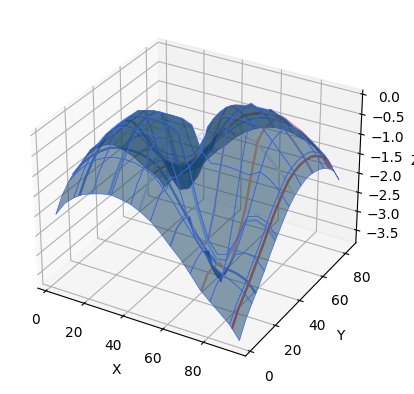

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')
X, Y = np.meshgrid(x_i,y_j)
X= np.transpose(X)
Y=np.transpose(Y)
Z = flux_moments[0]

# Plot the 3D surface
ax.plot_surface(X, Y, np.log10(Z), edgecolor='royalblue', lw=0.5, rstride=2, cstride=2,
                alpha=0.5)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
ax.contour(X, Y, np.log10(Z), zdir='x', cmap='coolwarm')
ax.contour(X, Y, np.log10(Z) , zdir='y', cmap='coolwarm')
ax.contour(X, Y, np.log10(Z),  zdir='x', cmap='coolwarm')
ax.contour(X, Y, np.log10(Z) , zdir='y', cmap='coolwarm')

ax.set(
    xlabel='X', ylabel='Y', zlabel='Z')

plt.show()